In [ ]:
import os, sys, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

SEED = 42
keras.utils.set_random_seed(SEED)

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
df = pd.read_csv(
    'tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df.rename(columns={'content': 'sentence', 'sentiment': 'label'}, inplace=True)

df = df[ (df.label == 'happiness') | (df.label == 'sadness') ]
df.label = df.label.cat.remove_unused_categories()

label_names = df.label.cat.categories.tolist()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

print(f'{len(train_df)=}, {len(test_df)=}')
print(label_names)

len(train_df)=8299, len(test_df)=2075
['happiness', 'sadness']


,label,sentence
23531,sadness,&quot;My problem isn't that I miss you... 'cau...
8051,sadness,That's it? It's done already? This is one proo...
11499,sadness,I am so hungry! And there is no food for me to...
31288,happiness,Feet hurt...finally in bed...will not forget t...
18561,sadness,really ill atm


,label,sentence
11535,sadness,looks like we're rained out for weekend climbing
32287,sadness,Hi Everyone miss me much? muahhhhhhhhhhhhhhhh...
17534,sadness,"rode the moped to the mall. fun stuff, its fli..."
4696,sadness,gutted!!! vodafone wont repair my faulty Samsu...
23706,happiness,"@shadowowns aww, &lt;3 why thank youu."


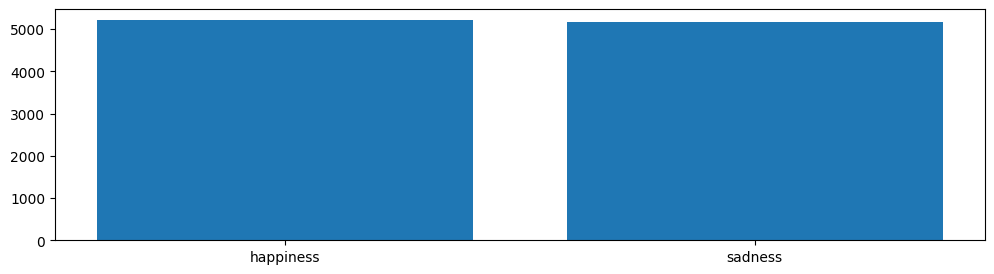

In [ ]:
display(train_df.head())
display(test_df.head())

plt.figure(figsize=(12,3))
plt.bar(x=label_names, height=np.bincount(df['label'].cat.codes))

class_weights = dict(enumerate(
    compute_class_weight(
        class_weight="balanced",
        classes=pd.unique(df['label']),
        y=df['label']
    )
))

In [ ]:
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 필요한 리소스를 다운로드합니다.
nltk.download('stopwords')
nltk.download('wordnet')

# 정규표현식 패턴 정의
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUMBERS = re.compile('\d+')

# NLTK에서 제공하는 불용어 리스트
STOPWORDS = set(stopwords.words('english'))
# NLTK에서 제공하는 워드넷 레마타이저
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'http\S+', '')
    text = tf.strings.regex_replace(text, '([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ')
    text = tf.strings.regex_replace(text, '[/(){}\[\]\|@,;]', ' ')
    text = tf.strings.regex_replace(text, '[^0-9a-z #+_]', '')
    text = tf.strings.regex_replace(text, '[\d+]', '')
    return text

def lemmatize_tokenize(text):
    # NLTK에서 불용어 제거 및 토큰화 후 레마타이징
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model

In [ ]:
import re
import string
import tensorflow as tf
from tensorflow import keras

@keras.saving.register_keras_serializable()
def clean_text(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.regex_replace(text, '\n', ' ')
    return text


In [ ]:
#new
import joblib

# 모델 정의
vectorizer_layer = layers.TextVectorization(
    max_tokens=5000,
    standardize=clean_text,
    output_sequence_length=256,
    output_mode='int'
)
vectorizer_layer.adapt(train_df.sentence)

In [ ]:
N_CLASSES = len(label_names)
MAX_FEATURES = 5_000
MAX_SEQ_LEN = 256
EMBEDDING_DIM = 128

vectorizer_layer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=clean_text,
#     split=lemmatize_tokenize,
    output_sequence_length=MAX_SEQ_LEN,
    output_mode='int'
)
vectorizer_layer.adapt(train_df.sentence)

In [ ]:
model = models.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorizer_layer,
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),

    layers.SpatialDropout1D(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='gelu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax'),#original :(N_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Train

In [ ]:
X_train, y_train = train_df.sentence, train_df.label.cat.codes
X_test,  y_test  =  test_df.sentence,  test_df.label.cat.codes

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=300,
    verbose=1,
    class_weight=class_weights,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/300
33/33 [==============================] - 5s 129ms/step - loss: 0.6887 - accuracy: 0.5504 - val_loss: 0.6767 - val_accuracy: 0.6901
Epoch 2/300
33/33 [==============================] - 4s 136ms/step - loss: 0.6434 - accuracy: 0.6826 - val_loss: 0.5811 - val_accuracy: 0.7571
Epoch 3/300
33/33 [==============================] - 9s 260ms/step - loss: 0.4992 - accuracy: 0.7831 - val_loss: 0.4544 - val_accuracy: 0.7836
Epoch 4/300
33/33 [==============================] - 7s 229ms/step - loss: 0.4030 - accuracy: 0.8250 - val_loss: 0.4284 - val_accuracy: 0.8048
Epoch 5/300
33/33 [==============================] - 8s 242ms/step - loss: 0.3458 - accuracy: 0.8579 - val_loss: 0.4182 - val_accuracy: 0.8111
Epoch 6/300
33/33 [==============================] - 4s 112ms/step - loss: 0.3044 - accuracy: 0.8778 - val_loss: 0.4167 - val_accuracy: 0.8145
Epoch 7/300
33/33 [==============================] - 4s 109ms/step - loss: 0.2671 - accuracy: 0.8928 - val_loss: 0.4224 - val_accuracy: 0.8125

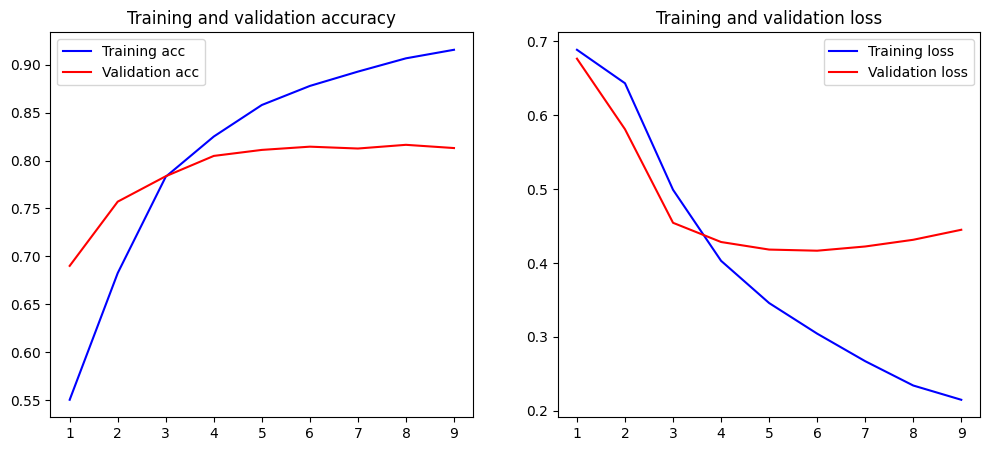

In [ ]:
def plot_history(history):
    acc,  val_acc  = history['accuracy'],  history['val_accuracy']
    loss, val_loss = history['loss'], history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)

    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy'); plt.legend(); plt.subplot(1, 2, 2)

    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss'); plt.legend(); plt.show()

plot_history(history.history)

Evaluate

65/65 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

   happiness       0.80      0.82      0.81      1015
     sadness       0.82      0.81      0.82      1060

    accuracy                           0.81      2075
   macro avg       0.81      0.81      0.81      2075
weighted avg       0.81      0.81      0.81      2075



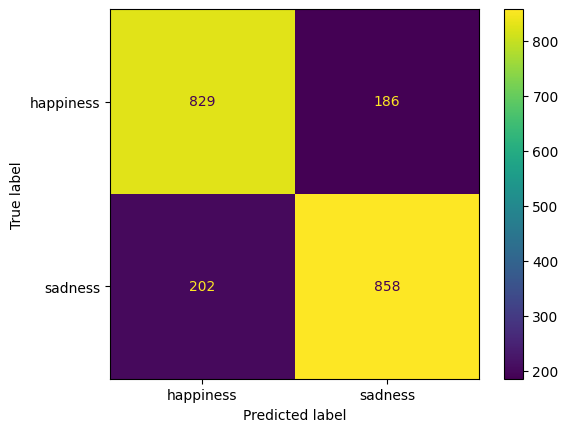

In [ ]:
y_pred = model.predict(X_test).argmax(1)

print(classification_report(
    y_test, y_pred, target_names=label_names
))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_names
)

In [ ]:
!pip install joblib

In [ ]:
import pickle
import joblib

In [ ]:
saved_model = pickle.dumps(model)

In [ ]:
joblib.dump(model, 'classifymodel2.pkl')

['classifymodel2.pkl']

In [ ]:
print(joblib.__verison__)

AttributeError: module 'joblib' has no attribute '__verison__'

In [ ]:
model_from_pkl = joblib.load('classifymodel2.pkl')

In [ ]:
model.save('sentimen_1', save_format='tf')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/sentimen_1 '/content/drive/My Drive/'

In [ ]:
!cp -r sentiment_1 '/content/drive/My Drive/'

cp: cannot stat 'sentiment_1': No such file or directory


Demo

In [ ]:
text = [
    "I wish you didn't have to go... everything is so much brighter when you are around",
    'this is amazing, I love it',
    "fuck this shit I am done",
    'meet me when you get back - I love being around you',
    'this is the worst trash I have ever tasted'
]

preds = model.predict(pd.Series(text)).argmax(1).squeeze()
print([label_names[pred] for pred in preds])

1/1 [==============================] - 0s 81ms/step
['sadness', 'happiness', 'sadness', 'happiness', 'sadness']


In [ ]:
text = ["this is amazing, I love it"]
preds = model_from_pkl.predict(pd.Series(text)).argmax(1).squeeze()
print([label_names[preds]])

1/1 [==============================] - 0s 227ms/step
['happiness']
